# Planificación del proyecto

Vamos a intentar predecir el valor real de la calidad del vino. 

El dataset a utilizar es el que aparece en la carpeta: [Wine Dataset](./Data_winequality-white.xlsx)

Los objetivos a cumplir son los siguientes:
- Construir una red neuronal utilizando PyTorch.
- ¿Se predice bien la calidad del vino?

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

import time
rn_state = 42

## 1. Lectura de datos y análisis básico.


In [4]:
# Cargar los datos
df_wine = pd.read_excel('Data_winequality-white.xlsx')

# Análisis básico
df_wine.head()  # Primeras filas del dataset

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [5]:
# Imprimir los tipos de datos
print('Tipos de datos del dataset: ')
print(df_wine.dtypes)
print('Valores de la variable quality:', df_wine.quality.unique())

Tipos de datos del dataset: 
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object
Valores de la variable quality: [6 5 7 8 4 3 9]


In [7]:
# Tamaño del dataset
df_wine.shape

(4898, 12)

In [8]:
# Buscamos si hay valores perdidos o no válidos
df_wine.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [9]:
# Vemos las principales métricas de las variables
df_wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


Numero de casos y su distribucion en el dataset de entrenamiento:  {3: 20, 4: 163, 5: 1457, 6: 2198, 7: 880, 8: 175, 9: 5}


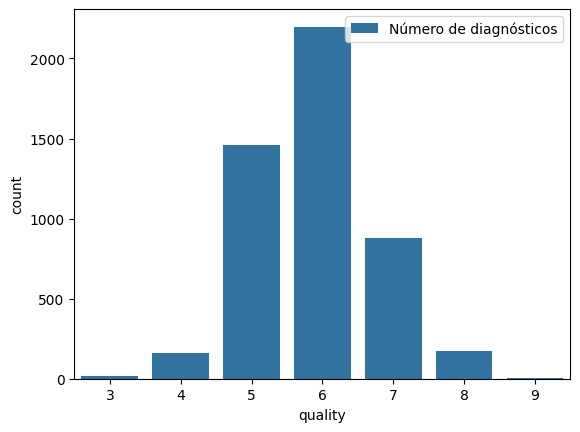

In [10]:
ax = sns.countplot(df_wine, x="quality", label="Número de diagnósticos") 
unique, counts = np.unique(df_wine['quality'], return_counts=True)
print("Numero de casos y su distribucion en el dataset de entrenamiento: ", dict(zip(unique, counts)))

## 2. Separación del conjunto de datos y estandarización de las variables.
- Dividimos el conjunto de datos en tres subconjuntos: entrenamiento (65%), validación (20%) y prueba (15%). 
- Estandarizamos las variables de entrada (features) pero no la variable objetivo.

In [11]:
y = df_wine['quality'].copy()
x = df_wine.drop('quality', axis=1)

# Separamos el conjunto de datos en entrenamiento y prueba
# Usamos 15% de los datos para el conjunto de test
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size = 0.15,
    shuffle=True,
    random_state = rn_state
)

print('x_train:', x_train.shape)
print('y_train:', y_train.shape)
print('x_test:', x_test.shape)
print('y_test:', y_test.shape)

x_train: (4163, 11)
y_train: (4163,)
x_test: (735, 11)
y_test: (735,)


In [12]:
# Escalamos los datos usando StandarScaler
sc = StandardScaler()
# Realizamos el ajuste y transform sobre los datos de entrenamiento, pero solamente transformaamos los datos de prueba
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [13]:
# Separamos el conjunto de entrenamiento en conjuntos de entrenamiento y validación
# Usamos 20% de estos datos para la validación
x_train, x_val, y_train, y_val = train_test_split(
    x_train, 
    y_train, 
    test_size=0.20, 
    shuffle=True, 
    random_state = rn_state
)

print('x_train:', x_train.shape)
print('y_train:', y_train.shape)
print('x_val:', x_val.shape)
print('y_val:', y_val.shape)

x_train: (3330, 11)
y_train: (3330,)
x_val: (833, 11)
y_val: (833,)


## 3. Creación de Datasets y DataLoaders en PyTorch
- Convertimos los datos estandarizados en tensores de PyTorch.
- Creamos los DataLoaders para facilitar el acceso por lotes a los datos.

In [14]:
# Dataset and DataLoader: define the function for the dataset
class WineDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(np.array(y).astype(np.float32), dtype=torch.float32)
    
    def __len__(self):
        # Devolver el número de ejemplos en el conjunto de datos
        return self.x.shape[0]
    
    def __getitem__(self, idx):
        # Devolver un ejemplo del dataset con la indice 'idx'
        return self.x[idx], self.y[idx]

In [15]:
train_dataset = WineDataset(x_train, y_train)
val_dataset = WineDataset(x_val, y_val)# Crear el dataset para los datos de validación
test_dataset = WineDataset(x_test, y_test)# Crear el dataset para los datos de validación

In [16]:
batch_size = 128 # Especificar este hiperparametro

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle= False)# Crear el DataLoader para los datos de validación
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)# Crear el DataLoader para los datos de prueba

In [17]:
# Vemos un batch de datos (un consiste en 32 ejemplos de datos)
for i_batch, (x_train, y_train) in enumerate(train_dataloader):
    print("número de batch :", i_batch)
    print("x_train en i_batch : ", x_train.size())
    print("y_train en i_batch :", y_train.size())
    break

número de batch : 0
x_train en i_batch :  torch.Size([128, 11])
y_train en i_batch : torch.Size([128])


## 4. Diseño del modelo
Definimos un modelo simple de red neuronal con PyTorch.

In [18]:
class WineQualityModel(nn.Module):
    def __init__(self, input_shape): # input_shape es el número de variables que vamos a usar para la predicción
        super(WineQualityModel, self).__init__()
        # Añadir las capas del modelo
        self.fc1 = nn.Linear(input_shape, 7) 
        self.fc2 = nn.Linear(7, 4) 
        self.fc3 = nn.Linear(4, 1) 
     
    def forward(self, x):
        # Añadir los pasos a seguir en el forward pass
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
      
        return x

In [19]:
model = WineQualityModel(input_shape=x.shape[1])

### 4.1. Hiperparámetros, funición de coste y optimizador
- Definimos los hiperparámetros como el número de épocas y la tasa de aprendizaje.
- Seleccionamos la función de error cuadrático medio (MSE) como la función de coste, ya que es adecuada para problemas de regresión.
- Seleccionamos el optimizador, especificando la tasa de aprendizaje.

In [20]:
learning_rate = 0.001 # Especificar la tasa de aprendizaje
epochs = 150# Especificar número de épocas

optimizer = torch.optim.SGD(params=model.parameters(), lr=learning_rate)# Especificar el optimizador con la tasa de aprendizaje y parametros del modelo
loss_fn = nn.MSELoss()# Especificar la función de coste

### 4.2. Función de Entrenamiento y la funciión de Validación.
- Creamos una función para entrenar el modelo.
- Creamos una función para validar el modelo.

In [22]:
# Función de entrenamiento
def train(model, train_dataloader, optimizer, loss_fn):
    model.train()
    epoch_loss = 0
    for i_batch, (x_train, y_train) in enumerate(train_dataloader):
        
        # Pon a cero los gradientes para cada batch
        optimizer.zero_grad()

        # Calcula la salida (predicciones) del modelo para los ejemplos del batch
        predicciones = model(x_train)
        
        # Calcula el coste (función de coste con los valores predichos y reales)
        batch_loss = loss_fn(predicciones, y_train.reshape(-1,1))

        # Calcula los gradientes
        batch_loss.backward()
        
        # Ajuste los pesos
        optimizer.step()

        epoch_loss += batch_loss.item()
    
    loss_train = epoch_loss / i_batch
    
    return loss_train

# Función de validación
def evaluation(model, val_dataloader, loss_fn):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():

        for i_batch, (x_val, y_val) in enumerate(val_dataloader):

            # Calcula la salida (predicciones) del modelo para los ejemplos del batch
            predicciones = model(x_val)

            # Calcula el coste (función de coste con los valores reales y predichos)
            batch_loss = loss_fn(predicciones, y_val.reshape(-1,1))
            
            epoch_loss += batch_loss.item()
    
    loss_val = epoch_loss / i_batch
    
    return loss_val

### 4.3. Bucle de entrenamiento y validación.
Entrenamos el modelo a través de múltiples épocas y validamos en cada época.

In [23]:
def training_evaluation_loop(epochs, model, train_dataloader, val_dataloader, optimizer, loss_fn):
    # Empty loss and accuracy lists to track values
    start = time.time()

    loss_values_train = []
    loss_values_val = []

    for epoch in range(epochs):

        # Llama la función para el entrenamiento 
        loss_train = train(model, train_dataloader, optimizer, loss_fn)
        loss_values_train.append(loss_train)

        # Llama la función para la evaluación
        loss_val = evaluation(model, val_dataloader, loss_fn)
        loss_values_val.append(loss_val)

        # Imprime cada 10 épocas loss_train y loss_val
        if epoch % 10 == 0:
            print(f'Epoch: {epoch:4.0f} | Train Loss: {loss_train:.5f}, Validation Loss: {loss_val:.5f}')
    
    end = time.time()
    total_time = end - start

    print(f'Total training time: {total_time}')

    return loss_values_train, loss_values_val

### 4.5. Entrenamiento del modelo

In [24]:
loss_values_train, loss_values_val = training_evaluation_loop(epochs, 
                                                            model, 
                                                            train_dataloader, 
                                                            val_dataloader, 
                                                            optimizer, 
                                                            loss_fn)

Epoch:    0 | Train Loss: 31.32799, Validation Loss: 33.15028
Epoch:   10 | Train Loss: 1.38780, Validation Loss: 1.48576
Epoch:   20 | Train Loss: 0.78324, Validation Loss: 0.94562
Epoch:   30 | Train Loss: 0.72982, Validation Loss: 0.82741
Epoch:   40 | Train Loss: 0.64475, Validation Loss: 0.77635
Epoch:   50 | Train Loss: 0.59708, Validation Loss: 0.75096
Epoch:   60 | Train Loss: 0.59501, Validation Loss: 0.73488
Epoch:   70 | Train Loss: 0.65792, Validation Loss: 0.72409
Epoch:   80 | Train Loss: 0.59355, Validation Loss: 0.71411
Epoch:   90 | Train Loss: 0.58101, Validation Loss: 0.70713
Epoch:  100 | Train Loss: 0.63609, Validation Loss: 0.70234
Epoch:  110 | Train Loss: 0.56568, Validation Loss: 0.69877
Epoch:  120 | Train Loss: 0.56997, Validation Loss: 0.69550
Epoch:  130 | Train Loss: 0.62074, Validation Loss: 0.69255
Epoch:  140 | Train Loss: 0.59054, Validation Loss: 0.68969
Total training time: 5.052717924118042


### 4.5. Curva de aprendizaje
Graficamos las pérdidas de entrenamiento y validación a lo largo de las épocas.

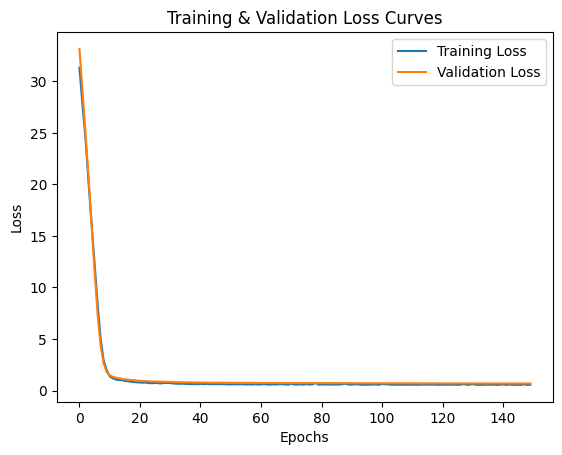

In [26]:
plt.plot(list(range(epochs)), loss_values_train, label='Training Loss')
plt.plot(list(range(epochs)), loss_values_val, label='Validation Loss')
plt.title('Training & Validation Loss Curves')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

## 5. Predicciones y cálculo del error.
Creamos una función para realizar predicciones en el conjunto de prueba y calcular el error.

In [27]:
def predictions(model, test_dataloader):
    predictions = []
    real_values = []

    model.eval()
    with torch.no_grad():
        for x_test, y_test in test_dataloader: 

            # Calula la salida (predicciones) del modelo para los ejemplos del batch
            outputs = model(x_test)
            

            predictions.append(outputs.detach().cpu().numpy())
            real_values.append(y_test.detach().cpu().numpy())

    predictions = np.vstack(predictions)
    real_values = np.hstack(real_values)
    
    # Calcula la métrica para la regresión para ver el error entre los valores predichos y reales
    mse = mean_squared_error(y_test, outputs)
    # Imprima la métrica
    print("Error Cuadrático Medio es:", mse)

    return predictions, real_values

In [28]:
predictions, real_values = predictions(model, test_dataloader)
preds_df = pd.DataFrame({'predictions': np.hstack(predictions), 'real_values': np.hstack(real_values)})
preds_df['error'] = np.abs(preds_df.real_values - preds_df.predictions)
preds_df

Error Cuadrático Medio es: 0.7072158


,predictions,real_values,error
0,5.955014,7.0,1.044986
1,6.610546,8.0,1.389454
2,6.443623,8.0,1.556377
3,5.555777,5.0,0.555777
4,6.206792,7.0,0.793208
...,...,...,...
730,5.223824,5.0,0.223824
731,5.637921,6.0,0.362079
732,6.736897,7.0,0.263103
733,6.146713,7.0,0.853287


## Conclusión

Un Error Cuadrático Medio (MSE) de 0.7223624 indica que, en promedio, las predicciones del modelo difieren del valor real en aproximadamente 0.85 unidades de la escala de calidad del vino, ya que la raíz cuadrada del MSE nos da una idea de la magnitud del error promedio.

### Interpretación del Resultado:
- **Aceptable**: En muchos casos, un MSE por debajo de 1.0 puede considerarse razonable, especialmente si la escala de la variable objetivo (calidad del vino) tiene un rango limitado (3 a 9). En este contexto, un error medio de 0.85 es relativamente bajo.
- **Mejorable**: Si el objetivo es lograr un modelo altamente preciso, se podría experimentar con diferentes arquitecturas de red, optimizadores, tasas de aprendizaje, o incluso aplicar técnicas de regularización para reducir el error.

### ¿Las predicciones salen más o menos bien?
Con un MSE de 0.72, el modelo tiene un desempeño aceptable, pero no perfecto. Esto sugiere que el modelo puede estar capturando la tendencia general en los datos, pero aún hay espacio para mejoras. Consideraciones para mejorar el rendimiento:
- **Hiperparámetros**: Ajustar el número de capas, neuronas, o la tasa de aprendizaje.
- **Regularización**: Añadir regularización L2 o dropout para evitar el sobreajuste.
- **Más datos**: Si es posible, aumentar el tamaño del conjunto de datos para mejorar el entrenamiento del modelo.
- **Ingeniería de características**: Revisar y mejorar la selección o transformación de características.